# Lab 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

444

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [4]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/mark/anaconda3/envs/OpenAI/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|█████████████████████████████████████████| 444/444 [04:22<00:00,  1.69it/s]


## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [6]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [7]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Was there significant turnover in the executive team? Yes, there was
significant turnover in the executive team during the reporting period.
As stated in the annual report, a total of three executives resigned or
retired from their positions, while five new executives were appointed
or hired. The departures included the Chief Financial Officer, Chief
Marketing Officer, and Chief Technology Officer, while the newly
appointed executives filled roles such as Chief Operating Officer,
Chief Human Resources Officer, and Chief Strategy Officer. The turnover
in the executive team was driven by a combination of strategic
realignment, retirement of long-serving executives, and 

In [8]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

part i item 1 information about our executiv e officers our executive
officers as of july 28, 2022 were as follows : name age position with
the company satya nadella 54 chairman of the board and chief executive
officer judson althoff 49 executive vice president and chief commercial
officer christopher c. capossela 52 executive vice president, marketing
and consumer business, and chief marketing officer kathleen t. hogan 56
executive vice president, human resources amy e. hood 50 executive vice
president, chief financial officer bradford l. smith 63 president and
vice chair christopher d. young 50 executive vice president, business
development, strategy, and ventures mr. nadella was appointed chairman
of the board in june 2021 and chief executive [UNK] in february 2014.
he served as executive vice president,

non - employee directors 10 - q 12 / 31 / 17 10. 14 1 / 31 / 18 10. 15
* microsoft corporation executive incentive plan 8 - k 10. 1 9 / 19 /
18 10. 19 * microsoft corporation execu

In [9]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


(0.974271410703659, 10.549678093194961, 3.548027181625366, 10.952874040603637)

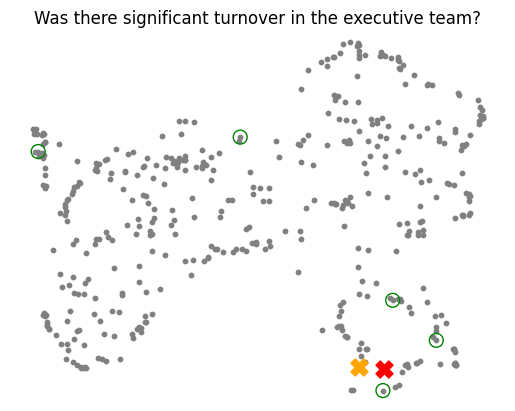

In [10]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [11]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [12]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the key drivers behind revenue growth?
How did the company achieve higher revenue compared to the previous year?
Were there any specific products or services that drove the increase in revenue?
Did the company expand into new markets that contributed to revenue growth?
How did changes in pricing affect the company's revenue?


In [13]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
part ii item 7 operating expenses increased $ 6. 3 billion or 14 %
driven by investments in cloud engineering, linkedin, gaming, and
commercial sales. key changes in operating expenses were : • research
and development expenses increased $ 3. 8 billion or 18 % driven by
investments in cloud engineering, gaming, and linkedin. • sales and
marketing expenses increased $ 1. 7 billion or 8 % driven by
investments in commercial sales and linkedin. sales and marketing
included a favorable foreign currency impact of 2 %. • general and
administrative expenses increased $ 793 million or 16 % driven by
investments in corporate functions. operating income increased $ 13. 5
billion or 19 % driven by growth across each of our segments. current
year net income and diluted eps were positively impacted by the net tax
beneﬁt related to the transfer of intangible properties, which resulted
in

cash from operat

In [14]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


In [15]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|███████████████████████████████████████████| 30/30 [00:17<00:00,  1.74it/s]


(0.974271410703659, 10.549678093194961, 3.548027181625366, 10.952874040603637)

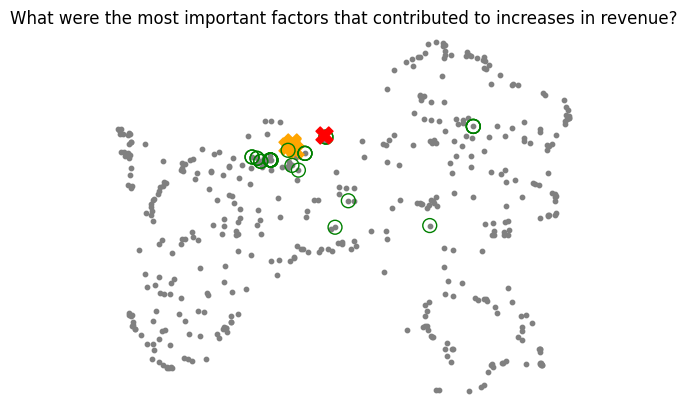

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')